Import libraries

In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.helpers import store_predictions_and_create_graph

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load dataset

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path)
df = df[[date_column, target_column, "New_cases_30_days_ago"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

In [3]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

Param grid for grid search

In [4]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

Tuning

In [5]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2024-04-13 21:05:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































chain 3 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status





































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)












































































































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   





















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)















chain 4 |          | 00:00 Status2024-04-13 21:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


2024-04-13 21:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 00:00 Sa

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)









































































chain 1 |██████████| 00:00 Sampling completed                   





















chain 2 |██████████| 00:00 Sampling completed                     












chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 3 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
















































































chain 1 |██████████| 00:00 Sampling completed                   
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     













chain 4 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:05:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:05:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-13 21:05:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























































































































chain 1 |██



































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                   









chain 4 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)










































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)























































































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   
















chain 4 |██████████| 00:00 Sampling completed









chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     









chain 2 |██████████| 00:00 Sampling completed












chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:05:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-04-13 21:05:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-04-13 21:05:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































2024-04-13 21:05:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |          | 00:00 Iteration: 226 /

chain 4 |██▌       | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   






























































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






















































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 1 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:05:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)NFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-04-13 21:05:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed  







chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   







chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed














chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed

2024-04-13 21:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









2024-04-13 21:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 4 |          | 00:00 Status2024-04-13 21:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




























































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed


chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





































































































cha




























































chain 1 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     













chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:05:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2024-04-13 21:05:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status2024-04-13 21:05:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-04-13 21:05:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)














































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2024-04-13 21:05:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)










chain 2 |          | 00:00 Status2024-04-13 21:05:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

































2024-04-13 21:05:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed               

chain 1 |          | 00:00 Status

























































chain 1 |██▌       | 00:00 Status



















































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   














chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                   g)
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 3 |          | 00:00 Status2024-04-13 21:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:05:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




















































































chain 1 |██████████| 00:00 Sampling completed                     



chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                   










chain 4 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed


chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                   


2024-04-13 21:05:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2024-04-13 21:05:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-13 21:05:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   

chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-04-13 21:05:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 2 |          | 00:00 Status2024-04-13 21:05:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |███████▌  | 00:00 Iterati















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

















chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   











chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   


2024-04-13 21:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-04-13 21:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)
































































chain 1 |██████████| 00:00 Sampling completed                     










































chain 2 |██████████| 00:00 Sampling completed                   
















chain 3 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                   


chain 1 |██████████| 00:00 Sampling completed                     

chain 3 |██████████| 00:00 Sampling completed                     A
chain 2 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:05:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2024-04-13 21:05:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









2024-04-13 21:05:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2024-04-13 21:05:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



































































































chain 1 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     




























































chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   










chain 1 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-04-13 21:06:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)









































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |████████

chain 1 |██▌       | 00:00 Status


















chain 1 |██████████| 00:00 Sampling completed                   




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   




























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 1 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:06:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status

























2024-04-13 21:06:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

















































2024-04-13 21:06:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:00 Sampling completed                     

















chain 2 

chain 3 |          | 00:00 Statusng completed                   

























chain 1 |██████████| 00:00 Sampling completed












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 3 |██▌       | 00:00 Status






















chain 1 |██████████| 00:00 Sampling completed                   








chain 2 |██████████| 00:00 Sampling completed









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-04-13 21:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-04-13 21:06:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling 


























































chain 1 |██████████| 00:00 Sampling completed                     

















chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-04-13 21:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-13 21:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:06:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   







chain 4 |██████████| 00:00 Sampling completed 


chain 4 |          | 00:00 Status

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |██████████| 00:00 Sampling completed                   g)












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     











chain 3 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed                     








chain 4 |██████████| 00:00 Sampling completed                   


chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































2024-04-13 21:06:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
























































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed













chain 2 |██████████| 00:00 Sampling completed                     














chain 3 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     














chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 3 |██▌       | 00:00 Status2024-04-13 21:06:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status2024-04-13 21:06:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)










































2024-04-13 21:06:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























































chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-04-13 21:06:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)


















































































































































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   












2024-04-13 21:06:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status












chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     


chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     




chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:06:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status
2024-04-13 21:06:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


















































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:06:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































2024-04-13 21:06:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status






















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





chain 4 |          | 00:00 Status

chain 1 |██▌       | 00:00 Status



chain 3 |██▌       | 00:00 Status

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed

2024-04-13 21:06:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:06:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















2024-04-13 21:06:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















































2024-04-13 21:06:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































chain 1 |██████████| 00:00 Sampling co


























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     











chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     














chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:06:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   


chain 4 |██████████| 00:00 Sampling completed

2024-04-13 21:06:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-04-13 21:06:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status














chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



































































2024-04-13 21:06:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |██████████| 00:00 Sampling comple





















chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     










































chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)








































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status














chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2024-04-13 21:06:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |███████▌  | 00:00 Iteration: 100 























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:06:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Status















































































































































chain 1 |██▌       | 00:00 Status
















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)










































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     















chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-04-13 21:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status











2024-04-13 21:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)





















2024-04-13 21:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


















chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2024-04-13 21:06:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











































































































































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     












chain 1 |██████████| 00:00 Sampling completed                     2024-04-13 21:06:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



2024-04-13 21:06:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     







chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status



















chain 3 |██▌       | 00:00 Status













2024-04-13 21:06:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:06:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     











chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

















































chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-04-13 21:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed




















2024-04-13 21:06:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status










































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 2 |          | 00:00 Status





chain 2 |██▌       | 00:00 Status



chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 2 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)
2024-04-13 21:06:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     




2024-04-13 21:06:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-04-13 21:06:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status

































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   
















2024-04-13 21:06:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |██████████| 00:00 Sampling completed                   

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     












2024-04-13 21:06:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


2024-04-13 21:06:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
















































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)


























2024-04-13 21:06:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |█████

chain 1 |          | 00:00 Status




































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     





















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:06:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 2 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:06:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:06:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































2024-04-13 21:06:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     


chain 4 |██████████| 00:00 Sampling completed                     


2024-04-13 21:06:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





2024-04-13 21:06:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)



















2024-04-13 21:06:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-13 21:06:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     





















chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling compl


chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status













chain 3 |██▌       | 00:00 Status





































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed                   

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:00 Sampling completed                     












chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-04-13 21:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-04-13 21:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:00 Sampling completed                     2024-04-13 21:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed              


chain 1 |          | 00:00 Status


























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)























































2024-04-13 21:06:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     





chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     






chain 4 |██████████| 00:00 Sampling completed                   


chain 3 |          | 00:00 Status












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     






chain 3 |██████████| 00:00 Sampling completed                     
chain 3 |██▌       | 00:00 Status


chain 4 |██████████| 00:00 Sampling completed                     






chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 4 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                   g)
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




2024-04-13 21:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 3 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     









chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   






















chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     














chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

2024-04-13 21:06:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-13 21:06:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)




































































































































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

































































chain 3 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |██████████| 00:00 Sampling completed                     


chain 2 |██████████| 00:00 Sampling completed                     


chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:06:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2024-04-13 21:06:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:00 Sampling completed                     










2024-04-13 21:06:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00








chain 1 |          | 00:00 Status
























































chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   













chain 4 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status
2024-04-13 21:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

































2024-04-13 21:06:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)










































chain 1 |██████████| 00:00 Sampling completed                   
chain 

















chain 1 |██▌       | 00:00 Status










































chain 1 |██████████| 00:00 Sampling completed                     






chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     




chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:01 Sampling completed                     
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 2 |██████████| 00:01 Sampling completed                     







chain 3 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                     

chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:06:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





2024-04-13 21:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-04-13 21:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-04-13 21:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed        

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























































































































chain 2 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)











































































2024-04-13 21:06:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status







chain 1 |██████████| 00:00 Sampling completed                     




chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |██████████| 00:00 Sampling completed                   

2024-04-13 21:06:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

















2024-04-13 21:06:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:00 Iteration: 200 / 250 [ 80%]  (Warmup)









































































ch

chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     














chain 1 |██████████| 00:00 Sampling completed                     
chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:06:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status









chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 4


chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                   












chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     

2024-04-13 21:06:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:06:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:06:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |          | 00:00 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                   
chain 4 |

2024-04-13 21:06:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00
























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     









2024-04-13 21:07:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























2024-04-13 21:07:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:07:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2024-04-13 21:07:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































































chain 1 |██████████| 00:07 Sampling completed            




2024-04-13 21:07:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     








chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |          | 00:00 Status




































































2024-04-13 21:07:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     







chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:07:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































2024-04-13 21:07:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     











2024-04-13 21:07:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
































































2024-04-13 21:07:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:07:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-04-13 21:07:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2024-04-13 21:07:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



















































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





























2024-04-13 21:07:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














2024-04-13 21:07:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)




chain 4 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-04-13 21:07:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


















2024-04-13 21:07:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




chain 3 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 2 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)












































2024-04-13 21:07:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



























































2024-04-13 21:07:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































2024-04-13 21:07:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






















2024-04-13 21:07:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     















2024-04-13 21:07:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)



























































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





















chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
















2024-04-13 21:07:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status
















2024-04-13 21:07:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)






























2024-04-13 21:07:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














































































2024-04-13 21:07:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status2024-04-13 21:07:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-13 21:07:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     










2024-04-13 21:07:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



















































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-13 21:07:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-13 21:07:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:07:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
































2024-04-13 21:07:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
























2024-04-13 21:08:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:08:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















































2024-04-13 21:08:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Status



















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     























chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:08:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































2024-04-13 21:08:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed            



chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-04-13 21:08:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-13 21:08:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)







































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     












chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)













2024-04-13 21:08:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status

























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     














chain 4 |██████████| 00:02 Sampling completed                     
























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:08:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:08:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)







2024-04-13 21:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






























2024-04-13 21:08:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status























































































2024-04-13 21:08:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-13 21:08:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



2024-04-13 21:08:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     














2024-04-13 21:08:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status
























































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     















































2024-04-13 21:08:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     












2024-04-13 21:08:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2024-04-13 21:08:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     















































2024-04-13 21:08:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     














chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




2024-04-13 21:08:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































2024-04-13 21:08:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     











chain 2 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status








































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


































2024-04-13 21:08:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     


chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-04-13 21:08:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 4 |██▌       | 00:00 Status

2024-04-13 21:08:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:08:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     























2024-04-13 21:08:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
























































2024-04-13 21:08:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-04-13 21:08:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







2024-04-13 21:08:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































































































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




2024-04-13 21:08:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:08:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)















































































2024-04-13 21:08:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed     

2024-04-13 21:08:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status





































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


















2024-04-13 21:08:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















2024-04-13 21:08:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)




































2024-04-13 21:08:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)














































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     











chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



2024-04-13 21:08:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 4 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)












































2024-04-13 21:08:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











2024-04-13 21:08:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)















2024-04-13 21:08:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     














chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


2024-04-13 21:08:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status











2024-04-13 21:08:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     














2024-04-13 21:08:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
































2024-04-13 21:08:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:07 Sampling completed                     




chain 2 |██████████| 00:07 Sampling completed
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









































2024-04-13 21:09:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     








































2024-04-13 21:09:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-04-13 21:09:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 4 |          | 00:00 Status















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:09:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























2024-04-13 21:09:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:09:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-04-13 21:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status












































2024-04-13 21:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)













































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:09:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
























2024-04-13 21:09:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status










chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)













2024-04-13 21:09:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)






































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     




















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



2024-04-13 21:09:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:04 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |          | 00:00 Status













2024-04-13 21:09:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:09:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

























































































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sa









chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-04-13 21:09:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:09:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-04-13 21:09:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:09:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































































































































2024-04-13 21:09:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

















chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:09:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














2024-04-13 21:09:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status











































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2024-04-13 21:09:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-13 21:09:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:09:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-04-13 21:09:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     









2024-04-13 21:09:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






























2024-04-13 21:09:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




chain 3 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)















































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



2024-04-13 21:09:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     


chain 3 |██████████| 00:06 Sampling completed                     


chain 4 |██████████| 00:06 Sampling completed                     











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:09:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:09:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██▌       | 00:00 Status




















2024-04-13 21:09:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)






















































































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sam

































2024-04-13 21:09:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:00 Status














































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     















chain 1 |██████████| 00:12 Sampling completed                     


chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     


chain 2 |██████████| 00:09 Sampling completed                     

chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-13 21:09:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















2024-04-13 21:09:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































2024-04-13 21:09:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






















2024-04-13 21:10:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




















chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)




















2024-04-13 21:10:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:10:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-13 21:10:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










2024-04-13 21:10:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     









































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

2024-04-13 21:10:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     













2024-04-13 21:10:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status












2024-04-13 21:10:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:10:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:10:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)












































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



























































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)












































2024-04-13 21:10:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     










chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     










































































2024-04-13 21:10:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




























2024-04-13 21:10:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:10:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

























































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















2024-04-13 21:10:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:10:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























2024-04-13 21:10:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:10:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)







































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
























2024-04-13 21:10:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     










2024-04-13 21:10:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:10:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     















































2024-04-13 21:10:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     































































2024-04-13 21:10:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














































































2024-04-13 21:10:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     






































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


















































































2024-04-13 21:10:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:10:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)

































chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:10:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
























2024-04-13 21:10:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:10:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:10:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
















































































































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

















































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 3 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:10:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-13 21:11:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:11:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-04-13 21:11:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:11:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:11:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:11:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
































































chain 4 |██▌       | 00:00 Status2024-04-13 21:11:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)
























2024-04-13 21:11:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:11:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status





2024-04-13 21:11:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     
























2024-04-13 21:11:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     









































2024-04-13 21:11:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:11:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)








2024-04-13 21:11:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























2024-04-13 21:11:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)












2024-04-13 21:11:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)














































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 3 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)







2024-04-13 21:11:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


















2024-04-13 21:11:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     








































































2024-04-13 21:11:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     


chain 4 |██████████| 00:06 Sampling completed                     























chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:11:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:11:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:11:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:11:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     












chain 2 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:11:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






















2024-04-13 21:11:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)





































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:11:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:11:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




2024-04-13 21:11:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     











chain 1 |██████████| 00:10 Sampling completed                     2024-04-13 21:11:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




















































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:11:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:11:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     












2024-04-13 21:12:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






2024-04-13 21:12:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








2024-04-13 21:12:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-04-13 21:12:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:12:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:12:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)













































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)














































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 2 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)







































2024-04-13 21:12:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |          | 00:00 Status









































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






2024-04-13 21:12:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:12:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:12:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)










































2024-04-13 21:12:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





















2024-04-13 21:12:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



















2024-04-13 21:12:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:12:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)

































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


















































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


2024-04-13 21:12:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

































2024-04-13 21:12:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     







chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:12:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-04-13 21:12:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)


































































































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |█████████



















































































2024-04-13 21:12:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














2024-04-13 21:12:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     

chain 3 |██▌       | 00:00 Status










2024-04-13 21:12:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2024-04-13 21:12:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




































2024-04-13 21:13:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     



























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)













2024-04-13 21:13:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































2024-04-13 21:13:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
























2024-04-13 21:13:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     






















chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




















2024-04-13 21:13:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     











































2024-04-13 21:13:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status





















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:13:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



















































2024-04-13 21:13:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:13:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     





2024-04-13 21:13:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:07 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:00 Status



























































2024-04-13 21:13:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:13:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:13:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




2024-04-13 21:13:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     















2024-04-13 21:13:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:13:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)


























































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)
















































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)















chain 3 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:13:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














2024-04-13 21:13:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     






chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2024-04-13 21:13:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































2024-04-13 21:13:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-04-13 21:13:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































2024-04-13 21:13:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:13:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































2024-04-13 21:13:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     












chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






































chain 3 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
























2024-04-13 21:13:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |          | 00:00 Status




































2024-04-13 21:13:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





































































2024-04-13 21:13:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)











































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     








chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-04-13 21:13:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-13 21:13:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-04-13 21:13:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
























































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03






















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
















2024-04-13 21:13:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status
































































































2024-04-13 21:13:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














2024-04-13 21:13:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































2024-04-13 21:13:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



















chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-04-13 21:13:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     















2024-04-13 21:13:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

























2024-04-13 21:13:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












































2024-04-13 21:13:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     












2024-04-13 21:14:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































2024-04-13 21:14:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     












2024-04-13 21:14:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:14:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






















2024-04-13 21:14:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status


























































































































































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



















2024-04-13 21:14:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     










chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-13 21:14:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

















2024-04-13 21:14:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






















2024-04-13 21:14:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















chain 2 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)



































2024-04-13 21:14:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 4 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)


























2024-04-13 21:14:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     



2024-04-13 21:14:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:11 Iteration: 226 / 250 [ 90%]  (Sampling)


































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     












2024-04-13 21:14:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Status










































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     











chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














2024-04-13 21:14:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-04-13 21:14:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:14:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)












































chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)



























































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling 
















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     








chain 4 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)2024-04-13 21:14:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


2024-04-13 21:14:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































2024-04-13 21:14:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     


















2024-04-13 21:14:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



chain 2 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)









2024-04-13 21:14:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:14:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

































































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)









































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)
















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     




















2024-04-13 21:14:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






































2024-04-13 21:14:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     











chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:15:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 3 |██▌       | 00:00 Status2024-04-13 21:15:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-04-13 21:15:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)


























































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





















2024-04-13 21:15:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



























































2024-04-13 21:15:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     















2024-04-13 21:15:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:15:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)












chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




2024-04-13 21:15:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:15:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)


















































2024-04-13 21:15:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     









chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:15:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-04-13 21:15:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status























































2024-04-13 21:15:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:15:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-13 21:15:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)










































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampli












chain 3 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 4 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     
































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


















chain 1 |██████████| 00:06 Sampling completed                     


chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:15:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
2024-04-13 21:15:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















2024-04-13 21:15:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:15:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































































































































2024-04-13 21:15:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     










2024-04-13 21:15:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-04-13 21:15:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:15:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)










































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)












































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)




















2024-04-13 21:15:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 2 |          | 00:00 Status



























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





































































































2024-04-13 21:15:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:15:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:15:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































chain 2 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 2 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)









































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     










chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-13 21:15:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:15:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)








































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed               














2024-04-13 21:15:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     














chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:15:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



2024-04-13 21:15:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























2024-04-13 21:15:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





















2024-04-13 21:15:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)












































































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:15:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 4 |██▌       | 00:00 Status

chain 3 |██▌       | 00:00 Status
















chain 2 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)








2024-04-13 21:15:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































2024-04-13 21:16:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-04-13 21:16:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:16:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status




















































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






































2024-04-13 21:16:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












2024-04-13 21:16:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     






chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



2024-04-13 21:16:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


























2024-04-13 21:16:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     




















































2024-04-13 21:16:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     











chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 3 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 4 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)


















2024-04-13 21:16:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)








2024-04-13 21:16:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)




















































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     








2024-04-13 21:16:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     
















chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:16:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     










2024-04-13 21:16:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     























2024-04-13 21:16:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:16:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)






































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




















































2024-04-13 21:16:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     









2024-04-13 21:16:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












































2024-04-13 21:16:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     















chain 2 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

























































































2024-04-13 21:16:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















2024-04-13 21:16:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


























2024-04-13 21:16:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













chain 1 |          | 00:00 Statusion: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:16:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     














chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






































2024-04-13 21:16:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































2024-04-13 21:16:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-13 21:16:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     






























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







2024-04-13 21:16:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status
















2024-04-13 21:16:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































2024-04-13 21:16:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:16:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

































































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)

















































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 4 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



2024-04-13 21:16:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























2024-04-13 21:16:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     





2024-04-13 21:16:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     






































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-04-13 21:16:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:16:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)2024-04-13 21:16:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     












2024-04-13 21:16:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 2 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)















































































2024-04-13 21:17:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Status



































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-04-13 21:17:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-13 21:17:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:17:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































2024-04-13 21:17:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


















































































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)























chain 1 |████████









chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 3 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


2024-04-13 21:17:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
























2024-04-13 21:17:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















2024-04-13 21:17:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     



























2024-04-13 21:17:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)
















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)








2024-04-13 21:17:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)














































2024-04-13 21:17:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



















2024-04-13 21:17:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     











chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status



















2024-04-13 21:17:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































chain 3 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 3 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 3 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


























2024-04-13 21:17:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 3 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)














































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     









chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     








2024-04-13 21:17:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















2024-04-13 21:17:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     












2024-04-13 21:17:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:17:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     













2024-04-13 21:17:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)



















chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     





chain 4 |██████████| 00:08 Sampling completed                     





















2024-04-13 21:17:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |          | 00:00 Status



































































2024-04-13 21:17:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:17:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















2024-04-13 21:17:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     











































2024-04-13 21:17:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






2024-04-13 21:17:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     































2024-04-13 21:17:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:17:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)

















































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


























2024-04-13 21:17:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Status


















chain 1 |██▌       | 00:00 Status

















2024-04-13 21:17:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2024-04-13 21:17:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:17:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |█████     | 00:09 Iteration:   1 / 250 [  0%]  (Warmup)





































































































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)













































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     










chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     












2024-04-13 21:18:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status








2024-04-13 21:18:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:18:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed    

2024-04-13 21:18:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     







chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





















2024-04-13 21:18:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     










2024-04-13 21:18:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






2024-04-13 21:18:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     













chain 1 |██████████| 00:07 Sampling completed                     


chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


































2024-04-13 21:18:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























2024-04-13 21:18:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


chain 1 |███████▌  | 00:08 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)













2024-04-13 21:18:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     













2024-04-13 21:18:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






















































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:18:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



































2024-04-13 21:18:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2024-04-13 21:18:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     
































chain 2 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)





















2024-04-13 21:18:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2024-04-13 21:18:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status











































































2024-04-13 21:18:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:18:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































2024-04-13 21:18:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)

















































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed           











































chain 3 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
2024-04-13 21:18:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-04-13 21:18:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status















2024-04-13 21:18:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































2024-04-13 21:18:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampl

2024-04-13 21:18:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 1 |          | 00:00 Status














chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     
























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:18:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




















































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)














































































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




























































































2024-04-13 21:18:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status






2024-04-13 21:18:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |          | 00:00 Status

chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:18:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































2024-04-13 21:18:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                   

2024-04-13 21:18:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |          | 00:00 Status

















2024-04-13 21:18:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)



















chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     






























































2024-04-13 21:19:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |          | 00:00 Status







chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     













chain 3 |██████████| 00:10 Sampling completed                     

















chain 4 |██████████| 00:10 Sampling completed                     























2024-04-13 21:19:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





















chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:19:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-04-13 21:19:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)




























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain




































chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-13 21:19:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status























































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



























2024-04-13 21:19:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


2024-04-13 21:19:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2024-04-13 21:19:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

























































2024-04-13 21:19:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status









chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     













































2024-04-13 21:19:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)







2024-04-13 21:19:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     








chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-04-13 21:19:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














































2024-04-13 21:19:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















2024-04-13 21:19:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)





















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     









chain 3 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-04-13 21:19:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



































2024-04-13 21:19:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)













































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


















































































2024-04-13 21:19:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status


2024-04-13 21:19:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2024-04-13 21:19:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































2024-04-13 21:19:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







































2024-04-13 21:19:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-04-13 21:19:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:19:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:19:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

















chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)























2024-04-13 21:19:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-13 21:19:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


2024-04-13 21:19:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |██▌       | 00:00 Status

2024-04-13 21:19:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status























































































































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2024-04-13 21:19:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































2024-04-13 21:19:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:19:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

































2024-04-13 21:19:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     






2024-04-13 21:19:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 2 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:19:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2024-04-13 21:19:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)





































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

chain 4 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)













2024-04-13 21:20:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status









chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








































2024-04-13 21:20:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:20:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2024-04-13 21:20:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:10 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:10 Iteration: 226 / 250 [ 90%]  (Sampling)



























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     
























































chain 2 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:20:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















chain 1 |          | 00:00 Status


2024-04-13 21:20:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     






















2024-04-13 21:20:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


2024-04-13 21:20:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2024-04-13 21:20:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     





















2024-04-13 21:20:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:20:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)2024-04-13 21:20:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:20:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






2024-04-13 21:20:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)









































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     








2024-04-13 21:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















2024-04-13 21:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed  

2024-04-13 21:20:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     














chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 00:08 Sampling completed                     

chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:20:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |          | 00:00 Status






























2024-04-13 21:20:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-04-13 21:20:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:20:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     














2024-04-13 21:20:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










chain 1 |          | 00:00 Status



































































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     













chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     































2024-04-13 21:20:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 2 |██▌       | 00:00 Status2024-04-13 21:20:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     



2024-04-13 21:20:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     





chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


























2024-04-13 21:21:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status


























































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     










2024-04-13 21:21:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


























2024-04-13 21:21:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     





2024-04-13 21:21:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     



























































2024-04-13 21:21:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




















2024-04-13 21:21:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


























2024-04-13 21:21:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

2024-04-13 21:21:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














2024-04-13 21:21:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




































































2024-04-13 21:21:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































2024-04-13 21:21:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:21:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)




















































































chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)














































chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)





































chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed         

chain 2 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |██████████| 00:06 Sampling completed                     s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 1 |          | 00:00 Status








chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     


chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     








































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-04-13 21:21:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-04-13 21:21:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































2024-04-13 21:21:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)




































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed              

















2024-04-13 21:21:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     




chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

2024-04-13 21:21:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:21:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















chain 4 |          | 00:00 Status2024-04-13 21:21:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sam




































2024-04-13 21:21:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status






chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     














chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

chain 4 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-04-13 21:21:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     



chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     








chain 3 |          | 00:00 Status
















2024-04-13 21:21:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-13 21:21:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)













































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 















































2024-04-13 21:21:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     






chain 2 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed                     













chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     
























































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2024-04-13 21:21:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-04-13 21:21:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































2024-04-13 21:21:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)





































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain










chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 4 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)




































































































2024-04-13 21:21:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status











2024-04-13 21:21:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:21:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































2024-04-13 21:21:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     




chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)
2024-04-13 21:22:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




















2024-04-13 21:22:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status



























































































































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     




























chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     


2024-04-13 21:22:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































2024-04-13 21:22:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:09 Iteration: 226 / 250 [ 90%]  (Sampling)








































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-04-13 21:22:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























































































































































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)










































































chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     














chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















2024-04-13 21:22:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































2024-04-13 21:22:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


2024-04-13 21:22:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status






























































2024-04-13 21:22:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


































2024-04-13 21:22:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)



2024-04-13 21:22:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     



















































2024-04-13 21:22:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


































2024-04-13 21:22:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

















chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)



























chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)














2024-04-13 21:22:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     











chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

2024-04-13 21:22:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-13 21:22:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     















2024-04-13 21:22:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     






chain 1 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)

















2024-04-13 21:22:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     





























2024-04-13 21:22:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     







2024-04-13 21:22:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



























































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     
















chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 1 |███████▌  | 00:06 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     












chain 3 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-13 21:22:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status









2024-04-13 21:22:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































2024-04-13 21:22:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     

2024-04-13 21:22:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)














































































chain 1 |███████▌  | 00:07 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:08 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 00:08 Iteration: 226 / 250 [ 90%]  (Sampling)













































































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sa


chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     


chain 3 |██████████| 00:09 Sampling completed                     


chain 4 |██████████| 00:09 Sampling completed                     











chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


















2024-04-13 21:22:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











chain 1 |          | 00:00 Statusion: 200 / 250 [ 80%]  (Warmup)2024-04-13 21:22:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██▌       | 00:00 Status



















2024-04-13 21:22:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     






























2024-04-13 21:22:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)












































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)



































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













chain 4 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     











































2024-04-13 21:23:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |          | 00:00 Status



























chain 1 |██▌       | 00:00 Status2024-04-13 21:23:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2024-04-13 21:23:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:23:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)
























































































chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)































































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling comple












chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     










chain 4 |██████████| 00:03 Sampling completed                     












chain 3 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)











































chain 1 |██████████| 00:03 Sampling completed                   
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-13 21:23:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-13 21:23:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:23:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































2024-04-13 21:23:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)






































































































































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



















chain 2 |██████████| 00:06 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |██████████| 00:06 Sampling completed                     
chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


chain 4 |██████████| 00:06 Sampling completed                     

2024-04-13 21:23:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:23:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status















2024-04-13 21:23:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-13 21:23:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)















































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


2024-04-13 21:23:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     




















2024-04-13 21:23:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status






2024-04-13 21:23:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

2024-04-13 21:23:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     









































chain 1 |███████▌  | 00:09 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:09 Iteration: 200 / 250 [ 80%]  (Warmup)























































chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     












chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     





















chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     

Best option

In [6]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 2430.391029184249,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 2419.3368747654695,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 2438.691716673453,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 2449.5667356885738,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 2446.362602286813,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 6280.909591182764,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 6281.472122082153,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 2432.2867630575447,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 6311.587890205972,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.8}': 6288.705462495858,
 '{"seasonality": null, "level_sm

In [7]:
ets_best_params

{'seasonality': 360, 'level_sm_input': 1, 'seasonality_sm_input': 0.3}

Train model

In [8]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2024-04-13 21:23:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |██████████| 00:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:07 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     

Predict

In [19]:
forecast_df = test[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(test, on=date_column, how="left")

In [20]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot results

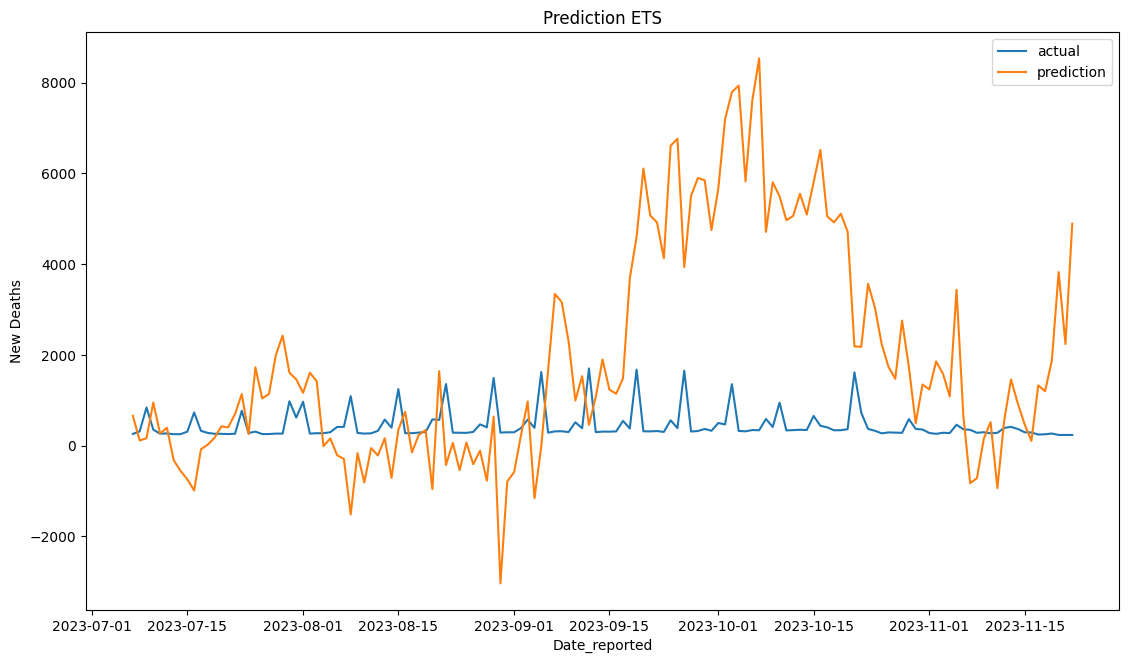

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction ETS")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

Metrics

In [23]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 8100665.57
RMSE: 2846.17
MAE: 2015.16
MAPE: 544.92
SMAPE: 138.58
MASE: 1.17


Store model

In [22]:
store_model(ets, "ets")

Store results and depict them on graph

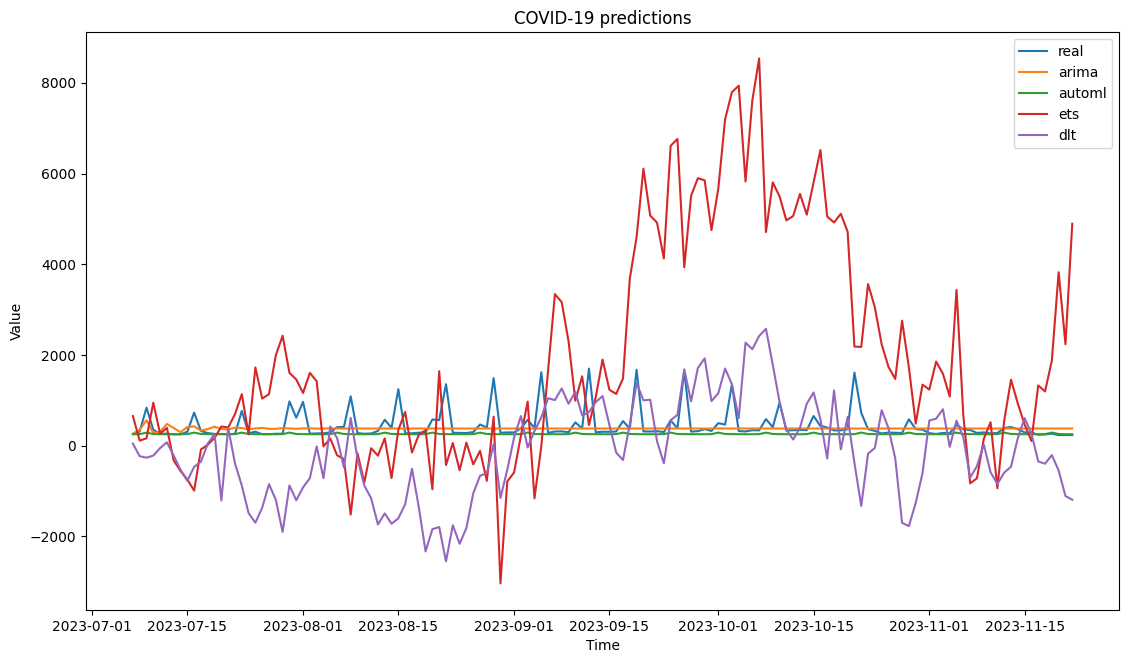

In [24]:
store_predictions_and_create_graph("ets", p[date_column], non_zero, p[target_column]-1, "COVID-19")

Param grid for tuning

In [13]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

Grid search

In [14]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["New_cases_30_days_ago"],
        regressor_sign=["+"],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status


chain 2 |          | 00:00 Status














chain 1 |██▌       | 00:00 Status






































































































































































































































































chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)




























































































chain 1 |███████▌  | 00:22 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |██████████| 00:22 Iteration: 200 / 250 [ 80%]  (Warmup)































chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Samp





















































chain 1 |██████████| 00:25 Sampling completed                     









chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     















chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status


















































































































































chain 1 |██████████| 00:29 Sampling completed                     
chain 2 |██████████| 00:29 Sampling completed                     
chain 3 |██████████| 00:29 Sampling completed                     
chain 4 |██████████| 00:29 Sampling completed                     















































chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     











































chain 1 |█████     | 00:13 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 00:17 Iteration: 226 / 250 [ 90%]  (Sampling)



























































chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     











































chain 1 |          | 00:00 Status













































































































































































































































chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     

































































































chain 1 |██████████| 00:32 Sampling completed                     
chain 2 |██████████| 00:32 Sampling completed                     
chain 3 |██████████| 00:32 Sampling completed                     
chain 4 |██████████| 00:32 Sampling completed                     







































































































chain 1 |██████████| 00:31 Sampling completed                     
chain 2 |██████████| 00:31 Sampling completed                     
chain 3 |██████████| 00:31 Sampling completed                     
chain 4 |██████████| 00:31 Sampling completed                     

chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)





















































chain 1 |██████████| 00:22 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 00:26 Sampling completed                     
chain 2 |██████████| 00:26 Sampling completed                     
chain 3 |██████████| 00:26 Sampling completed                     
chain 4 |██████████| 00:26 Sampling completed                     

chain 1 |          | 00:00 Status





























































































































































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     






















































































































































































































chain 1 |██████████| 00:31 Sampling completed                     
chain 2 |██████████| 00:31 Sampling completed                     
chain 3 |██████████| 00:31 Sampling completed                     
chain 4 |██████████| 00:31 Sampling completed                     


























































































chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     




















































chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)

















































chain 1 |██████████| 00:27 Sampling completed                     
chain 2 |██████████| 00:27 Sampling completed                     
chain 3 |██████████| 00:27 Sampling completed                     
chain 4 |██████████| 00:27 Sampling completed                     

















































chain 1 |          | 00:00 Status






























































































chain 1 |██████████| 00:24 Sampling completed                     
chain 2 |██████████| 00:24 Sampling completed                     
chain 3 |██████████| 00:24 Sampling completed                     
chain 4 |██████████| 00:24 Sampling completed                     















































































































































































































































































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     


chain 1 |██████████| 00:31 Sampling completed                     
chain 2 |██████████| 00:31 Sampling completed                     
chain 3 |██████████| 00:31 Sampling completed                     
chain 4 |██████████| 00:31 Sampling completed                     

chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)























































































































































chain 1 |███████▌  | 00:26 Iteration: 100 / 250 [ 40%]  (Warmup)
























chain 1 |██████████| 00:27 Iteration: 200 / 250 [ 80%]  (Warmup)




































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     






































































chain 1 |██████████| 00:29 Sampling completed                     
chain 2 |██████████| 00:29 Sampling completed                     
chain 3 |██████████| 00:29 Sampling completed                     
chain 4 |██████████| 00:29 Sampling completed                     


















































































































































































































































chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     




chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     

In [15]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_best_params

{'global_trend_option': 'linear'}

Model training

In [16]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    regressor_sign=["+"],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)


chain 1 |          | 00:00 Status








chain 1 |█████     | 00:27 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:32 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:33 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:34 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:36 Sampling completed                     
chain 2 |██████████| 00:36 Sampling completed                     
chain 3 |██████████| 00:36 Sampling completed                     
chain 4 |██████████| 00:36 Sampling completed                     

Predict

In [11]:
p = dlt.predict(df=test[[date_column, "New_cases_30_days_ago"]])
p = p.merge(test, on=date_column, how="left")

In [12]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot results

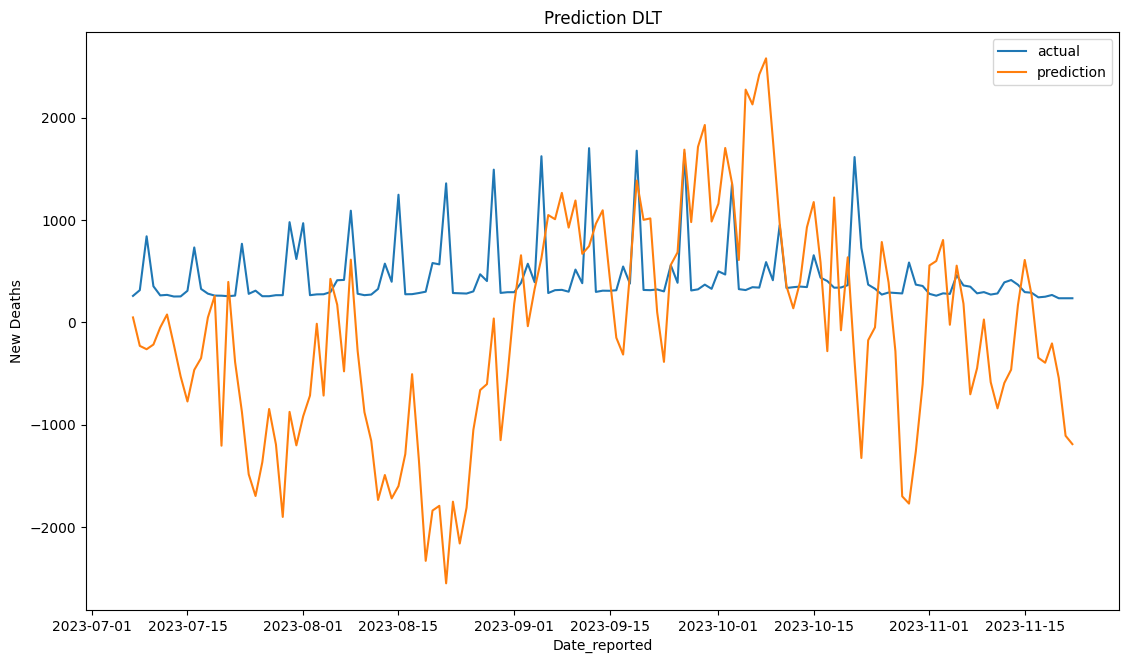

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction DLT")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

Metrics

In [14]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 1434626.83
RMSE: 1197.76
MAE: 942.87
MAPE: 253.93
SMAPE: 143.74
MASE: 0.55


Store model

In [15]:
store_model(dlt, "dlt")

Store results and depict them on graph

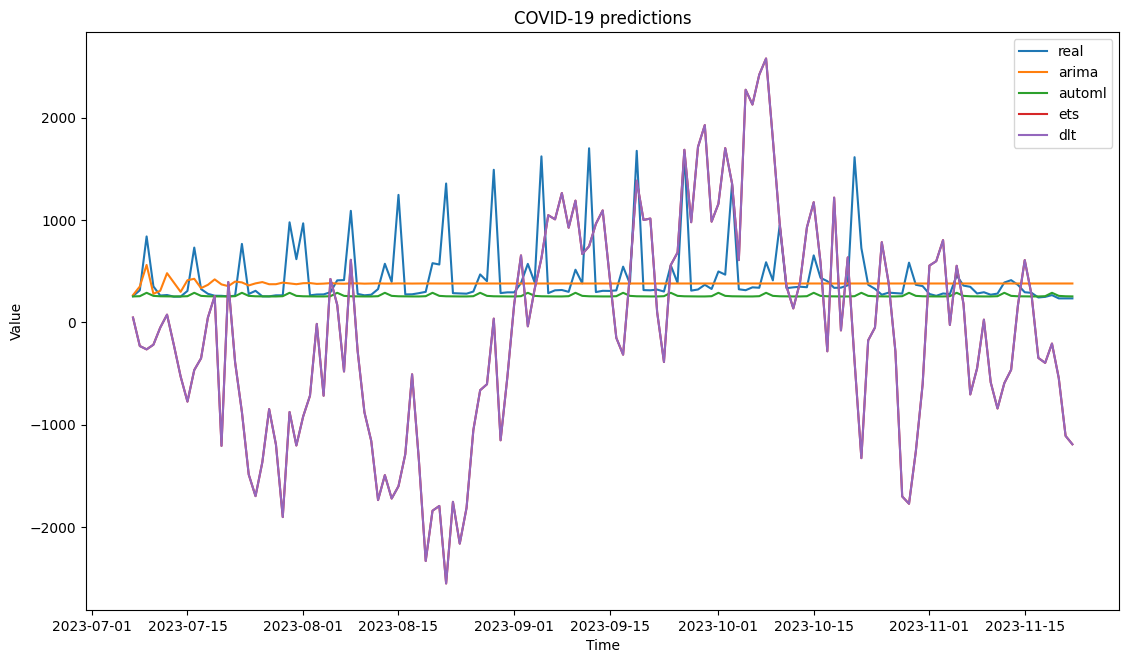

In [18]:
store_predictions_and_create_graph("dlt", p[date_column], non_zero, p[target_column]-1, "COVID-19")

Param grid for tuning

In [4]:
seasonality = [7, 14, 30, 90, 180, 360]

def all_possible_sublists(lst):
    n = len(lst)
    sublists = []
     
    for start in range(n):
        for end in range(start + 1, n + 1):
            sublists.append(lst[start:end])
     
    return sublists


sublists = all_possible_sublists(seasonality)
param_grid = {"seasonality": sublists, "seed": [1,2,3,4,5]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

Grid search

In [5]:
ktr_scores = dict()


def ktr_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    verbose=False,
    **grid
)

for option in combinations_as_dicts:
    _, score = evaluate_grid(ktr_function, option, train, date_column, target_column)
    ktr_scores[json.dumps(option)] = score

2024-04-14 15:44:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
2024-04-14 15:44:24 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-14 15:44:28 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-14 15:44:31 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-14 15:44:35 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-14 15:44:40 - orbit - INFO - Optimizi

Best params

In [6]:
ktr_best_params = json.loads(min(ktr_scores, key=ktr_scores.get))
ktr_best_params

{'seasonality': [30], 'seed': 5}

Train model

In [7]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["New_cases_30_days_ago"],
    verbose=False,
    **ktr_best_params
)

ktr.fit(df=train)

2024-04-14 16:21:38 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


Predict

In [26]:
p = ktr.predict(df=test[[date_column, "New_cases_30_days_ago"]])
p = p.merge(test, on=date_column, how="left")

In [27]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot results

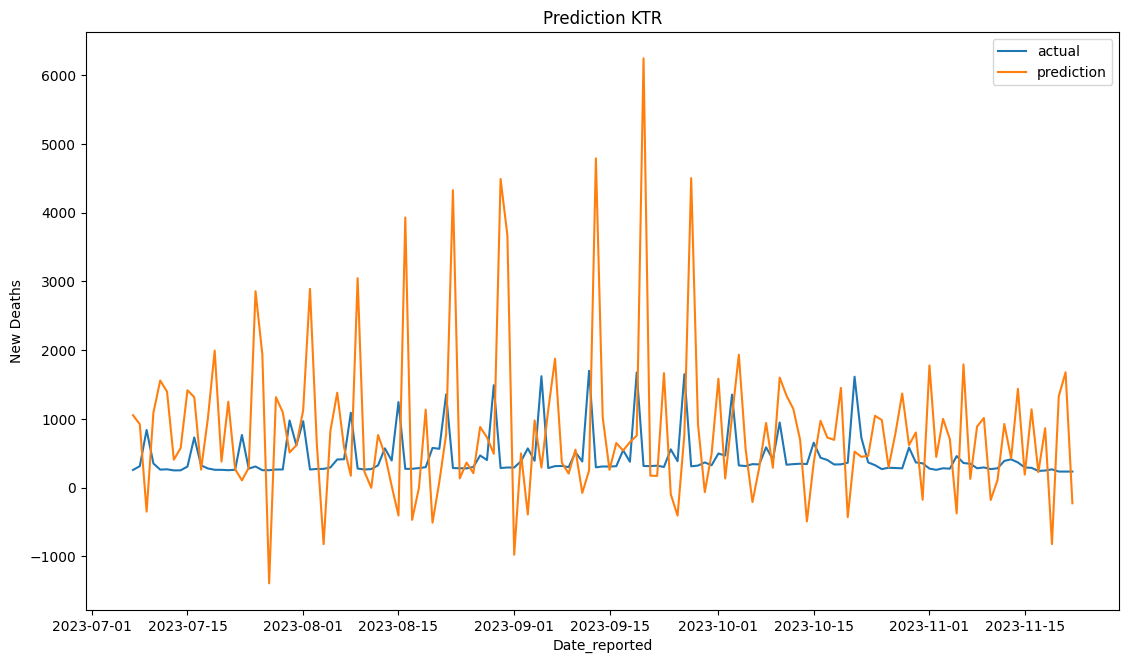

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction KTR")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

Metrics

In [29]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 1640623.72
RMSE: 1280.87
MAE: 841.27
MAPE: 251.14
SMAPE: 105.93
MASE: 0.49


Store model

In [30]:
store_model(ktr, "ktr")

Store results and depict them on graph

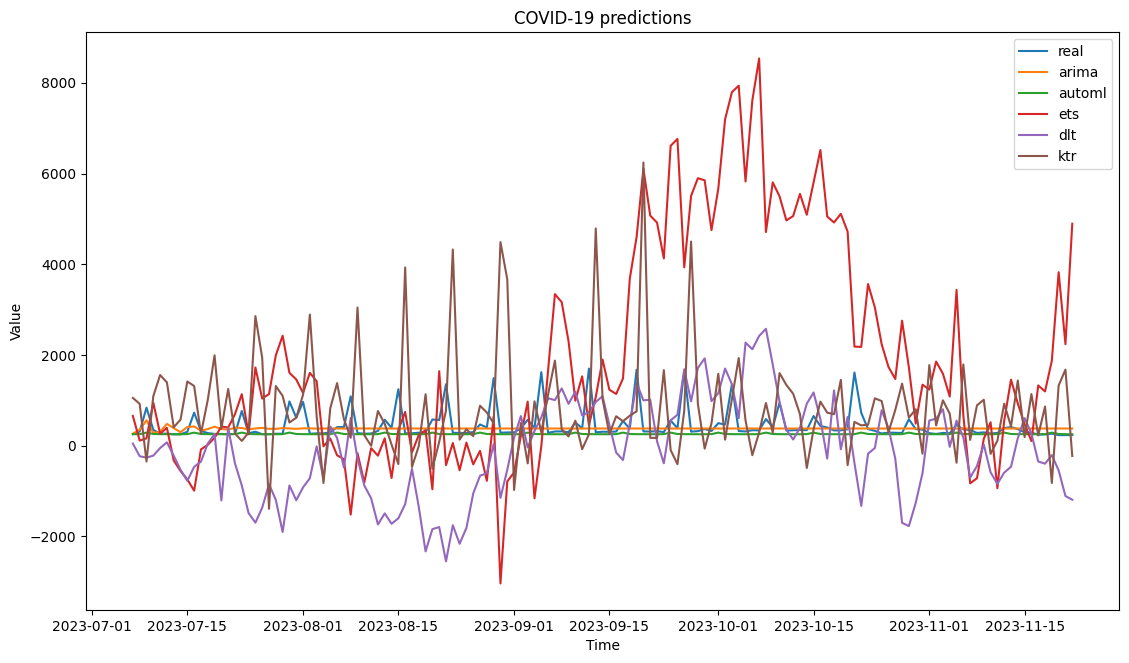

In [31]:
store_predictions_and_create_graph("ktr", p[date_column], non_zero, p[target_column]-1, "COVID-19")